In [1]:
%matplotlib inline 
#above line makes matplotlib plots appear in the notebook (instead of a separate window)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, Math, Latex
from scipy.fft import rfft2, irfft2, fft2, ifft2, rfft, irfft, fftfreq
import random
import os
import sympy as sym
from sympy import Symbol
from sympy.solvers import solve
from numba import jit

In [2]:
N = 100 #Define the number of grid points along x and y  
dx = 2 / (N-1) #Define the grid spacing in the x direction
dy = 2 / (N-1) #Define the grid spacing in the y direction
#nt = 100    #nt is the number of timesteps we want to calculate
#dt = .00001  #dt is the amount of time each timestep covers (delta t)
#k = np.sqrt(1/(dx**2+dy**2))
kx = 2*np.pi/(N**2)
ky = 2*np.pi/(N**2)
k = np.sqrt(kx**2+ky**2)
#phi=[[random.uniform(-.1,.1) for i in range(N)] for j in range(N)] #Initialize our order paramter matrix with values between -1 and 1
#phi = np.asarray(phi)
#print(phi)

In [3]:
def get_initial_configuration(N):
    ###Assign initial conditions
    nx = N
    ny = N
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    u = np.ones((ny, nx))  # create a nx x ny array of 1s
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u=[[random.uniform(-.1,.1) for i in range(N)] for j in range(N)]
    
    return u

In [4]:
#Define the 2d Laplacian
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

In [1]:
help np.roll

SyntaxError: invalid syntax (<ipython-input-1-cdd37eeee491>, line 1)

In [5]:
#Define the 2 Laplacian - order 4
def f_laplacian_o4(Z,m):
    delta_x = 2.0/m
    return ((-1/12)*np.roll(Z,-2, axis = 0) + (4/3)*np.roll(Z,-1, axis = 0) + (4/3)*np.roll(Z,1, axis=0)-(1/12)*np.roll(Z,2, axis = 0)
           -(1/12)*np.roll(Z,-2, axis = 1) +(4/3)*np.roll(Z,-1, axis = 1) + (4/3)*np.roll(Z,1, axis=1)-(1/12)*np.roll(Z,2, axis = 1)
            -5*Z)/(delta_x**2)

In [6]:
def velocity(u,a,b,dx,dy,N):
    #psi = (a/(k**2.+b))*fft2(u)
    psi = np.ones((N,N))
    velx = np.ones((N,N))
    vely = np.ones((N,N))
    uprime = fft2(u)
    n_value = fftfreq(N,(1.0/N))
    kx_array = np.zeros((N,N),dtype = float)
    ky_array = np.zeros((N,N),dtype = float)
    x_length = 2
    y_length = 2
    for i in range(0,N):
        for j in range(0,N):
            kx_array[i][j]=(2*np.pi*n_value[j])/x_length
            ky_array[i][j]=(2*np.pi*n_value[i])/y_length
            #psi[i][j] = (a/((((-dx/N)*i)+(2/N))**2.+(((-dy/N)*j)+(2/N))**2.+b))*uprime[i][j]
            #velx[i][j] = uprime[i][j]*(complex(1)*((-dx/N)*i+(2/N)))
            #vely[i][j] = uprime[i][j]*(-complex(1)*((-dx/N)*j+(2/N)))
            velx[i][j] = uprime[i][j]*complex(1)*kx_array[i][j]*(a/((kx_array[i][j]**2.+ky_array[i][j]**2.)+b))
            vely[i][j] = uprime[i][j]*(-complex(1))*ky_array[i][j]*(a/((kx_array[i][j]**2.+ky_array[i][j]**2.)+b))
    #print((uprime.real)**2.+(uprime.imag)**2.)
#    imag = np.ones((N,N))
#    imag=[[complex(1) for i in range(N)] for l in range(N)]
    
#    velx = (2*np.pi/N)*psi
#    vely = (-(2*np.pi/N))*psi
    
#    velx,vely = np.multiply(velx,imag),np.multiply(vely,imag)
    
    velx, vely = np.real(ifft2(velx)), np.real(ifft2(vely))
    
    #velx, vely = (np.gradient(irfft2(psi)))[1], -(np.gradient(irfft2(psi)))[0]
    return velx, vely

In [7]:
velx,vely = velocity(phi,.01,0,dx,dy,N)

NameError: name 'phi' is not defined

In [8]:
velx

NameError: name 'velx' is not defined

In [9]:
#def first_time_step(u,VX,VY,dx,dy,t):
#    u = np.asarray(u)
#    clone = u.copy()
#    u = (fft2(clone)-t*(k**2)*fft2(clone**3-clone)-t*(complex(1)*(1/dx)*fft2(np.multiply(VX,clone))+complex(1)*(1/dy)*fft2(np.multiply(VY,clone))))/(1+t*(k**4))
#    u = np.real(ifft2(u))
#    return u

In [10]:
def phi_update(u,VX,VY,t):
    u = np.asarray(u)
    clone = u.copy()
    u = clone + (-(np.multiply(VX,(np.gradient(clone))[0])+np.multiply(VY,(np.gradient(clone))[1]))+discrete_laplacian(-clone + clone**3. - discrete_laplacian(clone)))*t
    #u = clone + (-((VX * (np.gradient(clone)[0]))+(VY * (np.gradient(clone)[1])))+discrete_laplacian(-clone + np.multiply(clone,clone,clone) - discrete_laplacian(clone)))*t
    #u = clone + (-(np.multiply(VX,(np.gradient(clone))[0])+np.multiply(VY,(np.gradient(clone))[1]))+discrete_laplacian(-clone + np.multiply(clone,clone,clone) - discrete_laplacian(clone)))*t
    return u

In [11]:
first_time_step(phi,velx,vely,dx,dy,dt)
newphi = first_time_step(phi,velx,vely,dx,dy,dt)

NameError: name 'first_time_step' is not defined

In [12]:
print(dt)
print(phi_update(phi,velx,vely,dt))

NameError: name 'dt' is not defined

In [13]:
def draw(u):
    """draw the concentrations"""
    fig, ax = plt.subplots(figsize=(5.65,4))
    ax.imshow(u, cmap='Greys')
    
    ax.set_title('u')
    ax.axis('off')

[[-0.06966771113166954, 0.06528023072822298, -0.04979727080490451, -0.054703363191703304, -0.0650300035930104, -0.07218696067360181, -0.030731768717529848, -0.0676501763096028, 0.00610078724667569, -0.031014095797384275, 0.03849016869085625, 0.017806480790234322, 0.02451305789424843, -0.07170527896967781, -0.08187153417098987, 0.05336862986755303, 0.06145896535446135, -0.04665762015505784, -0.024647412452871914, 0.0075384885266557705, -0.06845525542078343, 0.012397229893007733, -0.031679802380970776, -0.0019283509564834295, -0.00898487301954061, 0.0023832538640576884, 0.057458668314583405, -0.06717808119412634, 0.07347157585501352, -0.09997615233579996, 0.0999092062456487, -0.08434786361975438, 0.05139338656250117, -0.007710131761880984, -0.034560325690117605, 0.08857031080097741, 0.07866687420177679, 0.02546897145805227, -0.054333109034083706, -0.021024758679727126, 0.01553124816564222, -0.019623586353040776, 0.05378160963460696, 0.09955440862597267, 0.011994199435853822, -0.075277371

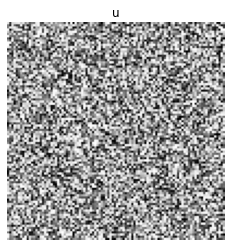

In [14]:
u = get_initial_configuration(N)
draw(u)
print(u)

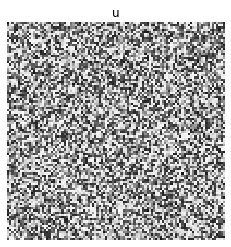

<ipython-input-6-fecd7396d8a3>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  velx[i][j] = uprime[i][j]*complex(1)*kx_array[i][j]*(a/((kx_array[i][j]**2.+ky_array[i][j]**2.)+b))
<ipython-input-6-fecd7396d8a3>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  vely[i][j] = uprime[i][j]*(-complex(1))*ky_array[i][j]*(a/((kx_array[i][j]**2.+ky_array[i][j]**2.)+b))


[[-1.50275896e-08  1.97523803e-08  7.03279893e-08 ... -2.23949026e-07
  -9.98917204e-09 -4.86055699e-08]
 [-5.36082632e-09 -6.63358230e-09  1.84529947e-08 ...  8.58863736e-08
  -1.10779848e-08  1.19059209e-08]
 [ 3.43622283e-08  1.52811485e-08  2.83388023e-09 ...  3.18076451e-08
  -1.19022059e-08 -2.25398688e-08]
 ...
 [ 2.49342042e-08  3.21798876e-09  1.59933187e-09 ... -4.18865644e-09
   7.84299066e-09  1.81498490e-08]
 [-1.53058821e-09  4.10772964e-09 -1.42790179e-09 ... -1.27882205e-07
  -3.95343632e-09  1.05440812e-08]
 [ 5.26247448e-08  3.28530803e-08 -8.87748477e-09 ...  5.84163174e-08
   5.53458569e-09 -6.20189795e-09]]
[[-1.89275308e-01  2.82325379e+00 -2.45934654e+00 ...  8.81074635e-01
   1.01676045e+00 -1.60025214e+00]
 [ 9.00681159e-01 -2.37347420e+00  1.62571900e+00 ...  8.41296640e-01
  -7.59453912e-01  6.40424973e-01]
 [-1.45897209e+00  1.47109546e+00  1.40554130e-01 ... -1.17100577e+00
   1.42670951e+00 -7.17846936e-01]
 ...
 [ 1.97539652e+00 -2.25392806e+00  5.3443787

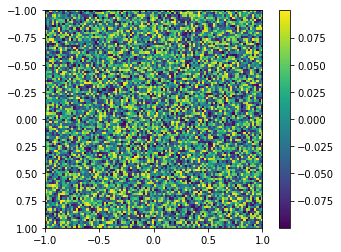

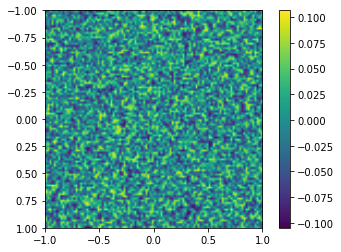

In [18]:
#This is taken from PHYS 230 notebook "PhaseSeparationModel.ipynb"

def forward_solver_full(a,b):
    
    

    # Set up grid
    N = 100
    dx = 2.0 / N
    dy = 2.0 / N
    x = np.linspace(-1.0, 1.0, N)
    y = np.linspace(-1.0, 1.0, N)
    
    x2 = np.linspace(-1.0, 1.0, int(N/4))
    y2 = np.linspace(-1.0, 1.0, int(N/4))
    
    Y, X = np.meshgrid(y, x)
    
    Y2, X2 = Y, X = np.meshgrid(y2, x2)

    # Initial data: randomize around average density
    #U = -0.2*np.ones((m,m)) + 2.0*np.random.randn(m, m)
    u = get_initial_configuration(N)
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1, aspect='equal')
    plot = plt.imshow(u, extent=(-1, 1, 1, -1), interpolation='nearest')
    fig.colorbar(plot)
    

    # Time: this is a longer time solution
    t = 0.0
    t_final = 0.8
    # time discretization chosen according to space discretization for convergence
    #delta_t = delta_x**4 / (0.25)
    dt = .01
    #num_steps = int(np.round(t_final / delta_t))
    num_steps = 10
    
    # Evolve in time
    next_output_time = 0.0
    for j in range(num_steps):
        velx, vely = velocity(u, a, b, dx, dy, N)
        if (t%1==0):
            u = np.asarray(u)
            print(np.multiply(velx,(np.gradient(u))[0])+np.multiply(vely,(np.gradient(u))[1]))
            print(discrete_laplacian(-u + u**3. - discrete_laplacian(u)))
        u = phi_update(u,velx,vely,dt)
        #u = first_time_step(u,velx,vely,dx,dy,dt)
        
        t += dt

        if t >= next_output_time:
            next_output_time += 1
            #print(velx)
            #print(vely)
           

            fig1 = plt.figure()
            axes1 = fig1.add_subplot(1, 1, 1, aspect='equal')
            plot1 = plt.imshow(u, extent=(-1, 1, 1, -1), interpolation='bilinear')
            
            #plt.streamplot(x,y,velx,vely,density = .7)
            #plt.quiver(X,Y,velx,vely)
            #print(np.multiply(velx,(np.gradient(clone))[0])+np.multiply(VY,(np.gradient(clone))[1]))
            fig1.colorbar(plot1)
            #axes1.set_title("t = %s" % t)
            head = (str(a)+'_'+str(b)+'_'+ str(t))
            
            my_path = os.path.abspath('a'+'_'+str(a)+'_'+'b'+'_'+str(b)+'_2')
            
            os.mkdir(my_path)
            
            name = (str(a)+'_'+str(b)+'_'+ str(t) + '.png')
            
            
            plt.savefig(os.path.join(my_path,name))
            
            #plt.imshow(velx)
            #plt.imshow(vely)
            plt.show()
            
            

    plt.show()
    
    # Parameters
forward_solver_full(a=0.1, b=1)

<ipython-input-6-fecd7396d8a3>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  velx[i][j] = uprime[i][j]*complex(1)*kx_array[i][j]*(a/((kx_array[i][j]**2.+ky_array[i][j]**2.)+b))
<ipython-input-6-fecd7396d8a3>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  vely[i][j] = uprime[i][j]*(-complex(1))*ky_array[i][j]*(a/((kx_array[i][j]**2.+ky_array[i][j]**2.)+b))


[[-4.98387095e-09  4.06296279e-09  2.73752771e-09 ... -1.08701099e-09
   3.65321913e-09 -4.68127666e-10]
 [-4.55912392e-11  4.71948256e-10  2.31595431e-10 ...  1.00122621e-09
   5.16176699e-10 -2.40962917e-09]
 [ 3.05628337e-10  1.68496878e-10 -5.65981418e-10 ...  1.96276458e-10
  -1.79008988e-09 -4.36202592e-09]
 ...
 [ 2.70035974e-09 -1.74629993e-10 -2.51296679e-10 ... -4.44256975e-10
   1.67625746e-09 -7.06876861e-10]
 [ 2.53685354e-09  2.31238022e-09 -2.58503262e-09 ... -9.93389040e-10
  -3.63217252e-09 -4.55338991e-09]
 [ 2.72828862e-09 -4.78120543e-09 -1.61466420e-09 ...  5.67732795e-10
  -3.23217174e-12  4.96892553e-09]]
[[ 0.697266   -1.8477767   1.06531863 ...  0.22189467 -0.40299138
   1.13298924]
 [-0.40252881  1.5785002  -0.87367227 ... -0.73139335 -0.24574994
  -0.66239589]
 [ 2.08962401 -2.06771676  0.75968932 ...  0.49891533  0.83745634
  -0.97915393]
 ...
 [ 2.07786381 -2.41733747  0.35489403 ...  2.58061766 -1.26806578
  -1.19817252]
 [-1.09635457  1.95443506  0.344802

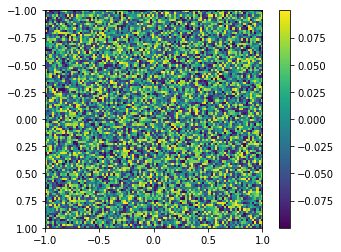

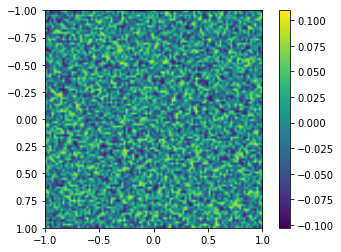

[[ 4.00076068e-08 -1.45334006e-08 -2.53349731e-08 ... -2.19025743e-08
   2.19995095e-09 -2.97443765e-09]
 [-5.32887520e-09 -3.22583499e-08  2.99382855e-09 ... -3.49776810e-08
   2.58860689e-08  2.69208664e-08]
 [-1.15436660e-09 -2.16661196e-09  2.35186494e-09 ... -2.06571451e-09
  -2.23216833e-08  7.56664999e-09]
 ...
 [-5.22098208e-09 -2.11196631e-09  3.04683766e-10 ...  4.67034568e-09
  -1.75632784e-08  3.70438772e-09]
 [-3.59153811e-08 -1.64815787e-09 -4.16226714e-09 ...  8.15877685e-09
   1.59041012e-08 -3.78060648e-09]
 [ 5.75029971e-08 -1.10154721e-08 -6.02760522e-08 ... -3.82714556e-08
  -5.21406130e-08  1.04071098e-08]]
[[-0.86437964 -1.34368383  2.58717693 ... -1.03763489  0.88248942
   0.41807168]
 [ 0.969908   -0.21685543 -1.31009759 ...  1.47413623 -1.75642058
   0.73962402]
 [ 0.2028827   0.92314016  0.33914649 ... -0.33604572  2.08511079
  -2.29784197]
 ...
 [ 0.4162906  -0.36311872 -0.87211576 ... -0.92285087 -0.58668431
   0.70136314]
 [-1.57166699  0.14773432  1.590461

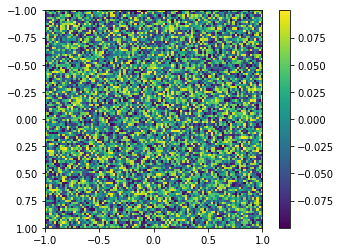

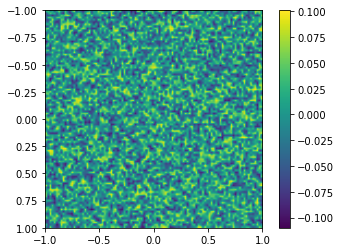

[[ 3.58781264e-08  1.15965451e-07 -1.43178291e-07 ... -7.14209341e-08
  -7.59658230e-08  4.32504357e-07]
 [-9.76665825e-08 -5.29652773e-08  1.00094743e-07 ... -9.56009279e-08
   1.45729854e-07  2.81315838e-08]
 [-2.29290948e-07 -1.19061354e-07 -2.96939438e-08 ... -6.63548577e-09
   1.39388450e-08  7.87554407e-08]
 ...
 [ 1.34480320e-07 -1.60953620e-08 -4.41809579e-08 ... -5.59049702e-08
   3.53942135e-09 -3.87230311e-08]
 [-2.25496511e-07 -1.54195207e-07 -2.05578525e-08 ...  1.69184569e-08
  -1.23772917e-08  5.05718952e-08]
 [ 1.00613598e-07  2.65729915e-07  3.47282962e-10 ... -5.67542549e-08
   1.06907917e-07 -1.77348672e-07]]
[[-1.61308291  1.52065679 -0.60734257 ...  0.14325136 -0.85274245
   1.51073732]
 [ 1.71081286 -0.39378571 -0.96733868 ...  0.40131628 -0.47313647
  -1.70801127]
 [-2.49770395  1.40943893  0.36708324 ... -0.73275742  1.55440073
   1.48541266]
 ...
 [ 0.13515511  1.35218136 -1.37751644 ... -0.86766698  0.19109543
   0.14549893]
 [-1.53130471  0.55697696  1.269049

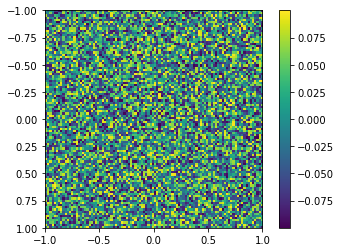

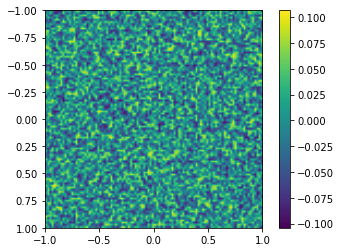

[[-5.51487619e-07 -3.44214015e-07  1.75941775e-06 ...  2.13969986e-06
  -9.34606511e-07 -1.73715918e-06]
 [-3.78263876e-07 -5.50032256e-07  8.77870623e-08 ...  1.35233130e-06
  -5.06305242e-07 -1.45343411e-06]
 [-5.75266372e-08  1.40105571e-06 -1.17193250e-06 ... -1.45906934e-06
   6.78631121e-07  1.42661610e-06]
 ...
 [ 7.43500018e-07  1.92635684e-07 -6.45432280e-08 ...  8.37021726e-07
   7.66174567e-07  3.05804816e-07]
 [ 7.61999629e-08  3.84771964e-07  4.55349166e-07 ... -5.44865757e-07
   3.76730893e-07  4.84672943e-09]
 [ 1.96268261e-06  5.82350710e-09  3.54086381e-07 ...  4.33757201e-07
   5.50436197e-07  6.86160990e-07]]
[[ 0.02522383 -0.09952855  1.55978607 ... -2.14007669  0.05875099
   0.61778119]
 [-0.26310607  0.4893275  -1.54339823 ...  2.49502501 -0.42827607
  -0.15212369]
 [ 1.38946237 -0.88435534  0.47610605 ... -1.47017955  1.5233269
  -1.96081739]
 ...
 [-2.5251466   0.5964271  -0.61944834 ... -2.11451419  0.60695562
   1.93064453]
 [ 1.53052425 -0.2415787   1.0668295

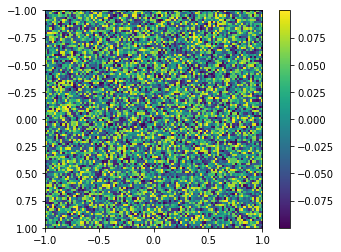

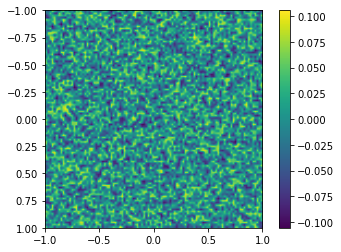

[[ 4.84840019e-05  2.67464266e-05 -4.58543624e-05 ...  7.75079150e-06
   1.03929873e-05  5.84738992e-05]
 [ 1.53627696e-05  2.44776623e-05 -2.85655707e-07 ...  1.67739458e-05
   1.37153329e-05  1.04204189e-05]
 [-3.11725160e-06 -1.36167762e-05 -4.78134503e-06 ...  8.82901539e-06
   1.12750408e-06 -9.62526205e-06]
 ...
 [-1.78068808e-05 -6.84772181e-06  9.89524215e-06 ... -1.63529243e-05
   5.94984085e-06 -1.69024701e-05]
 [ 8.78028303e-06 -2.74463231e-05 -1.92316533e-05 ...  5.31306438e-07
   3.21350932e-06 -1.76428948e-05]
 [-5.14566198e-06  2.02056885e-05  1.68544630e-05 ... -3.36678964e-06
   3.38796108e-07  2.83229568e-05]]
[[ 2.80051317 -0.776293   -0.28305133 ... -0.5585817   1.59975326
  -2.43732122]
 [-0.94540721 -0.50829771  0.50536983 ... -1.85060814  0.09276422
   0.69129601]
 [-0.66895249  0.61343817  0.20223315 ...  1.53169045 -0.45110001
   0.5978622 ]
 ...
 [ 0.51989461  0.43130022 -0.85903545 ... -0.21313563  0.96218324
  -0.45970219]
 [-0.69848775 -1.02264596  1.333094

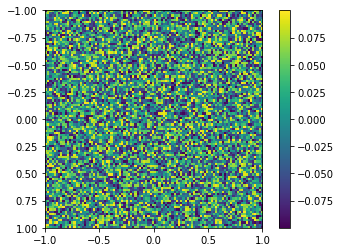

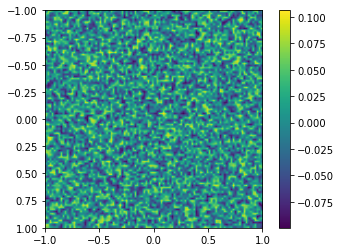

[[-3.46570803e-09 -2.01860708e-09  1.56424411e-09 ...  9.44754717e-10
  -2.36785526e-09  4.05134116e-09]
 [-2.74068314e-10 -5.52850421e-11  4.96114084e-11 ...  1.33559190e-10
  -7.11907670e-10  3.86961725e-10]
 [-1.02459646e-10  9.87862321e-11  1.33594098e-09 ... -7.17475725e-10
   3.64186937e-10  5.66360091e-10]
 ...
 [-2.15416511e-09 -9.78338754e-10  2.63710864e-09 ... -2.35860581e-09
  -1.96287589e-09  1.83064555e-09]
 [-5.40911218e-10  3.28156151e-10  1.48651757e-09 ...  3.28283917e-11
  -1.11966165e-09 -2.13777632e-10]
 [ 1.20242078e-09 -8.87044110e-10 -1.10789441e-09 ...  1.49924599e-09
  -1.86331659e-10 -8.51855571e-10]]
[[ 0.29419991 -1.35932707  0.76595196 ... -1.10510447  1.83235638
  -0.22312251]
 [-0.37518467  0.82575217  0.21735248 ... -0.39795236  0.70869275
  -0.82914536]
 [ 0.41039525 -0.73189084  0.01819261 ... -0.02294597 -1.32225409
   0.71534692]
 ...
 [-2.15302175  2.53220907 -1.30586574 ...  0.37931203 -0.16185048
   1.61332691]
 [ 0.16640965 -1.85693302  1.971107

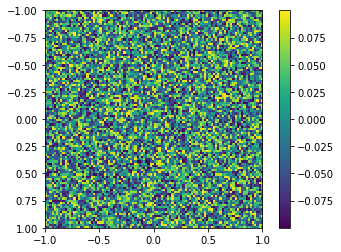

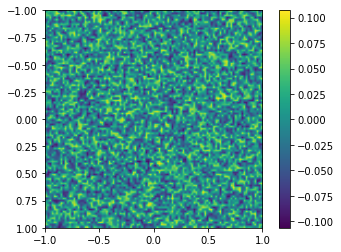

[[ 8.33915549e-09 -3.91397359e-09 -5.77827027e-09 ... -1.36406009e-08
  -4.26853090e-09  1.58743395e-08]
 [ 5.27356929e-09  1.95202091e-09 -4.06027543e-09 ...  4.83335148e-09
  -1.91984557e-09 -1.68096158e-08]
 [ 4.36326729e-09 -3.48532453e-09 -1.50198667e-09 ...  3.76463800e-09
  -1.34798015e-08 -1.80414898e-08]
 ...
 [ 1.24480238e-08  4.25923692e-10  7.75019224e-10 ... -7.39446325e-09
   1.12745596e-09  7.65934870e-09]
 [-1.77341224e-08 -8.94828813e-09 -5.67841174e-09 ...  1.51337468e-08
   6.33186886e-09  9.38964858e-09]
 [-7.11506585e-09 -6.44660898e-09 -2.05395250e-09 ... -2.89552657e-09
   3.02069026e-09 -8.33609167e-09]]
[[ 0.14800087  0.63651853 -0.77422569 ...  0.83996722 -1.3563631
   0.60995244]
 [-1.8395605   0.11930278  0.50303089 ... -1.19268709  0.00480879
   1.89270837]
 [ 1.94799858  0.23210819 -0.73432303 ...  0.94663524  0.02209513
  -2.06201785]
 ...
 [-0.30137048  0.8109308  -1.29593202 ... -0.21606605  0.22996641
  -0.0248727 ]
 [-1.22409703  1.15602962 -0.5299874

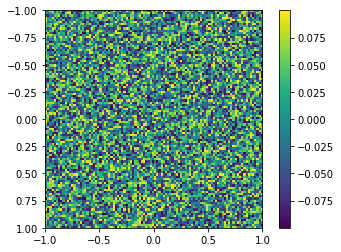

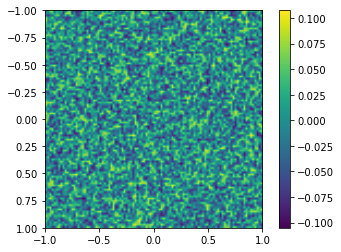

[[-2.54265923e-09  8.25167459e-08 -7.96105542e-08 ...  2.09631421e-07
   5.30295060e-08  4.18690607e-08]
 [-3.60217832e-07 -3.46664486e-08  1.23116736e-07 ... -7.73780416e-08
   9.96008908e-08 -9.46492089e-08]
 [ 6.85609160e-08  3.26664282e-08 -5.54362796e-08 ...  9.92718081e-09
  -1.38765142e-08  4.47055081e-09]
 ...
 [ 5.28998326e-08 -2.88908320e-08  2.50194370e-08 ...  8.92783095e-08
   7.41687769e-08  3.63662255e-08]
 [-5.02412122e-08  3.45624348e-08  1.70618267e-08 ...  1.25999208e-08
  -3.06926516e-08 -4.02124853e-08]
 [-2.16207185e-07 -7.80893816e-08 -2.71151968e-08 ...  4.50501662e-08
  -1.62508288e-07 -5.43051541e-08]]
[[-2.58989112e+00  1.50013733e+00  9.34077648e-01 ...  3.39956798e+00
  -2.72573212e+00  2.34688554e+00]
 [ 1.99253769e+00 -1.72321733e+00 -3.26896485e-01 ... -2.26048091e+00
   2.00447921e+00 -1.14262525e+00]
 [ 7.32569169e-02  4.25018575e-01 -6.40263915e-01 ...  6.49978838e-01
  -1.11500272e+00 -6.34739523e-01]
 ...
 [-1.69713288e+00 -2.44054392e-03 -4.3337896

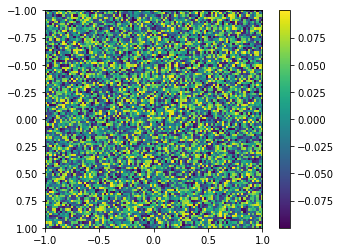

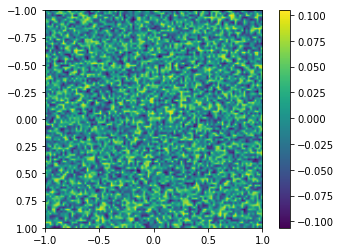

[[ 3.38594831e-07 -7.96532128e-07  1.59339398e-06 ... -1.80094534e-06
   1.34735923e-06  4.70208638e-06]
 [-8.41463485e-07 -1.29588196e-07  7.09450904e-07 ... -1.14979480e-07
   6.80138599e-07  2.43754748e-06]
 [ 2.92586712e-07 -2.69571104e-06  2.11090669e-06 ... -2.11321740e-08
   1.02573358e-06  3.25473498e-06]
 ...
 [-4.90420789e-07 -4.19323801e-07  9.26764933e-07 ... -1.00504236e-07
   9.54168419e-07 -9.74698636e-07]
 [-3.09479084e-06  7.53396608e-07 -5.13106812e-07 ...  7.92061528e-07
  -1.19460042e-06 -3.88142318e-06]
 [-6.40708636e-07  1.07516237e-06  8.92476033e-07 ... -1.22427299e-06
   2.20522406e-07  1.90754171e-06]]
[[ 1.46888843  0.06498026 -0.76967655 ...  0.73978844  1.02980209
  -2.29409985]
 [-0.38257761  0.70292826 -1.17810693 ... -0.77051339 -1.73157256
   2.38362357]
 [-0.15685339 -1.61591574  1.76762113 ...  0.47524169  1.78294486
  -1.78392202]
 ...
 [ 1.71077193 -0.85535228  1.2125278  ...  0.9460962   0.57565498
  -2.01737981]
 [-0.22296486  0.33463989 -1.780366

KeyboardInterrupt: 

In [22]:
aval = [0.001, 0.01, 0.1, 1, 10, 100]
bval = [0.001, 0.01, 0.1, 1, 10, 100]

for j in range(5):
    for i in range(5):
        forward_solver_full(aval[i], bval[j])

In [68]:
# Let's try real space
N = 50
#x = [[random.uniform(-1,1) for i in range(N)] for j in range(N)]
#y = [[random.uniform(-1,1) for i in range(N)] for j in range(N)]
X = sym.Matrix(sym.MatrixSymbol('X', N, N))
#@jit
def psi(phi,a,b):
    print(phi)
    #x = np.zeros((len(phi),len(phi)))
    #xnew = np.zeros((len(phi),len(phi)))
    phi = a*discrete_laplacian(phi)
    #for i in range(0,len(x)):
    #    for j in range(0,len(x)):
    sym.solve(f_laplacian_o4(X,N) + phi - b*discrete_laplacian(X),X)
    print(X)
    return X

In [69]:
x = [[random.uniform(-1,1) for i in range(N)] for j in range(N)]
y = [[random.uniform(-1,1) for i in range(N)] for j in range(N)]
x = np.asarray(x)
psi(x,.1,1)


[[-0.95781106 -0.51309613 -0.54750331 ... -0.11917608  0.06868631
  -0.4813292 ]
 [ 0.20599375 -0.47566376  0.41369984 ...  0.10872316 -0.54908841
  -0.59925258]
 [-0.65711354  0.09673973  0.98637418 ...  0.27066323  0.49848281
  -0.80112362]
 ...
 [-0.41001995  0.57516854 -0.62172664 ...  0.20718792 -0.71131008
   0.45175938]
 [ 0.14704539  0.75746621  0.90301188 ... -0.29714606  0.86341469
  -0.02960531]
 [-0.31552173 -0.11498459  0.5068582  ... -0.54754373  0.05522044
  -0.5270048 ]]


KeyboardInterrupt: 

In [111]:
u = get_initial_configuration(N)
velx,vely = velocity(u,.01,.001,dx,dy)

[[ 6.55592974e-03  4.18333331e-03 -6.92626230e-03 ... -2.32829827e-03
   3.63803555e-03 -3.90085951e-03]
 [-6.98891355e-03  3.27103393e-04 -5.24571244e-03 ... -6.53468781e-03
  -3.74710926e-04  8.59946149e-04]
 [ 5.75612994e-03 -5.26601245e-03  2.69808778e-03 ...  8.41405578e-05
   6.13882987e-03  1.14891140e-03]
 ...
 [-5.87842405e-03  4.34762261e-03 -4.57538291e-03 ... -2.87901504e-03
   1.02400641e-03  1.54054795e-03]
 [ 6.22482315e-03  4.60389965e-03  6.35177780e-03 ...  2.92022263e-03
   7.22222903e-04 -4.47037041e-03]
 [-3.45105860e-03 -4.51684680e-03  5.82415340e-03 ... -1.08377199e-03
   1.04276144e-03  2.44535549e-03]] [[-6.55592974e-03 -4.18333331e-03  6.92626230e-03 ...  2.32829827e-03
  -3.63803555e-03  3.90085951e-03]
 [ 6.98891355e-03 -3.27103393e-04  5.24571244e-03 ...  6.53468781e-03
   3.74710926e-04 -8.59946149e-04]
 [-5.75612994e-03  5.26601245e-03 -2.69808778e-03 ... -8.41405578e-05
  -6.13882987e-03 -1.14891140e-03]
 ...
 [ 5.87842405e-03 -4.34762261e-03  4.5753829

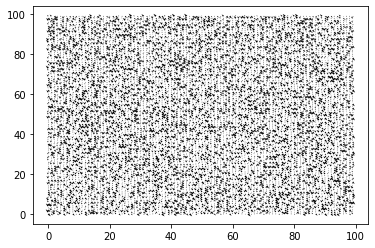

In [113]:
print(velx,vely)
plt.quiver(velx,vely)